In [1]:
%%capture
!pip install mujoco==2.3.3

In [2]:
%env MUJOCO_GL=egl

env: MUJOCO_GL=egl


## **Importing Required Libraries**

This cell imports essential libraries for implementing and visualizing Deep Deterministic Policy Gradient (DDPG) and Soft Actor-Critic (SAC). The key components include:


In [3]:
from   torch.optim import Adam
import torch
import torch.nn as nn
import torch.nn.functional as F
from   torch.distributions import Normal
import random
import numpy as np
import logging
import matplotlib
import matplotlib.pyplot as plt
import imageio
from IPython.display import HTML
from base64 import b64encode
import gymnasium as gym



is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display



logging.getLogger().setLevel(logging.ERROR)

# set up matplotlib
plt.ion()
plt.xkcd(scale=1, length=100, randomness=2)
matplotlib.rcParams['figure.figsize'] = (12, 6)

## **Logging, Visualization, and Video Playback Functions**


In [4]:
def plot_rewards(sum_of_rewards, show_result=None , bove = None,dn = None):
    plt.figure(1)
    rewards = torch.tensor(sum_of_rewards, dtype=torch.float)
    if show_result is not None:
        plt.title(f'{show_result}')
    else:
        plt.clf()
        plt.title('Training...')
    if bove is not None:
        plt.xlabel(f'{bove}')
    else:
        plt.xlabel('Episode')
    if dn is not None:
        plt.xlabel(f'{dn}')
    else:
        plt.ylabel('Reward')
    plt.plot(rewards.numpy())
    # Take 50 episode averages and plot them too
    length = len(rewards)
    init_len = min(49, length)
    init_means = np.cumsum(rewards[:init_len]) / (1 + np.arange(init_len))
    if length > 50:
        means = rewards.unfold(0, 50, 1).mean(1).view(-1)
        means = torch.cat((init_means, means))
    else:
        means = init_means
    plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())
def show_video(path):
    mp4 = open(path, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
    <video width=400 controls>
          <source src="%s" type="video/mp4">
    </video>
    """ % data_url)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## **Replay Memory for Experience Replay**

This class implements a **Replay Buffer**, a crucial component in off-policy reinforcement learning algorithms like DDPG and SAC. The buffer stores past experiences and allows the agent to sample them randomly, breaking correlation between consecutive samples and improving learning stability.

In [5]:
class ReplayMemory:
    def __init__(self, capacity, seed):
        random.seed(seed)
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done

    def __len__(self):
        return len(self.buffer)

## **Neural Networks for DDPG and SAC**

This cell defines key neural networks used in **Deep Deterministic Policy Gradient (DDPG)** and **Soft Actor-Critic (SAC)** algorithms.


- **`GaussianPolicy`**: A stochastic policy for SAC, using Gaussian action sampling.
- **`DeterministicPolicy`**: A deterministic actor for DDPG, applying action bounds.

In [6]:
# Initialize Policy weights
def weights_init_(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight, gain=1)
        torch.nn.init.constant_(m.bias, 0)


class ValueNetwork(nn.Module):
    def __init__(self, num_inputs, hidden_dim=512):
        """
        Extended Value Network with an additional hidden layer (3 layers total)
        and larger default hidden_dim.
        """
        super(ValueNetwork, self).__init__()
        
        self.linear1 = nn.Linear(num_inputs, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, 1)
        
        # Optional: Layer Norm can help stability
        # self.ln1 = nn.LayerNorm(hidden_dim)
        # self.ln2 = nn.LayerNorm(hidden_dim)
        # self.ln3 = nn.LayerNorm(hidden_dim)

        self.apply(weights_init_)

    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = self.out(x)
        return x


class QNetwork(nn.Module):
    """
    Twin Q-Networks with an extra hidden layer and bigger hidden_dim.
    """
    def __init__(self, num_inputs, num_actions, hidden_dim=512):
        super(QNetwork, self).__init__()
        
        # Q1
        self.q1_fc1 = nn.Linear(num_inputs + num_actions, hidden_dim)
        self.q1_fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.q1_fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.q1_out = nn.Linear(hidden_dim, 1)

        # Q2
        self.q2_fc1 = nn.Linear(num_inputs + num_actions, hidden_dim)
        self.q2_fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.q2_fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.q2_out = nn.Linear(hidden_dim, 1)

        self.apply(weights_init_)

    def forward(self, state, action):
        xu = torch.cat([state, action], dim=1)
        
        # Q1
        x1 = F.relu(self.q1_fc1(xu))
        x1 = F.relu(self.q1_fc2(x1))
        x1 = F.relu(self.q1_fc3(x1))
        Q1 = self.q1_out(x1)

        # Q2
        x2 = F.relu(self.q2_fc1(xu))
        x2 = F.relu(self.q2_fc2(x2))
        x2 = F.relu(self.q2_fc3(x2))
        Q2 = self.q2_out(x2)

        return Q1, Q2


LOG_SIG_MAX = 2
LOG_SIG_MIN = -20
epsilon = 1e-6

class GaussianPolicy(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_dim, action_space):
        super(GaussianPolicy, self).__init__()

        self.linear1 = nn.Linear(num_inputs, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, hidden_dim)

        self.mean_linear = nn.Linear(hidden_dim, num_actions)
        self.log_std_linear = nn.Linear(hidden_dim, num_actions)

        self.apply(weights_init_)
        
        # Register buffers so they move to GPU along with the model
        if action_space is not None:
            self.register_buffer("action_scale", torch.tensor((action_space.high - action_space.low) / 2., dtype=torch.float32))
            self.register_buffer("action_bias", torch.tensor((action_space.high + action_space.low) / 2., dtype=torch.float32))
        else:
            self.register_buffer("action_scale", torch.tensor(1.0))
            self.register_buffer("action_bias", torch.tensor(0.0))

    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        mean = self.mean_linear(x)
        log_std = self.log_std_linear(x)
        log_std = torch.clamp(log_std, min=LOG_SIG_MIN, max=LOG_SIG_MAX)
        return mean, log_std

    def sample(self, state):
        mean, log_std = self.forward(state)
        std = log_std.exp()
        normal = Normal(mean, std)
        x_t = normal.rsample()  # reparameterization trick
        y_t = torch.tanh(x_t)
        action = y_t * self.action_scale + self.action_bias  # action_scale and action_bias are now on the same device
        log_prob = normal.log_prob(x_t)
        log_prob -= torch.log(self.action_scale * (1 - y_t.pow(2)) + epsilon)
        log_prob = log_prob.sum(1, keepdim=True)
        mean = torch.tanh(mean) * self.action_scale + self.action_bias
        return action, log_prob, mean


class DeterministicPolicy(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_dim, action_space=None):
        super(DeterministicPolicy, self).__init__()
        self.linear1 = nn.Linear(num_inputs, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, hidden_dim)

        self.mean = nn.Linear(hidden_dim, num_actions)
        self.noise = torch.Tensor(num_actions)

        self.apply(weights_init_)

        # Register buffers so they move with the model to GPU
        if action_space is not None:
            self.register_buffer("action_scale", torch.tensor((action_space.high - action_space.low) / 2., dtype=torch.float32))
            self.register_buffer("action_bias", torch.tensor((action_space.high + action_space.low) / 2., dtype=torch.float32))
        else:
            self.register_buffer("action_scale", torch.tensor(1.0))
            self.register_buffer("action_bias", torch.tensor(0.0))

    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        mean = torch.tanh(self.mean(x)) * self.action_scale + self.action_bias
        return mean

    def sample(self, state):
        mean = self.forward(state)
        noise_std = 0.2  # Adjust noise standard deviation if needed
        noise = torch.randn_like(mean) * noise_std
        action = mean + noise
        return action, torch.tensor(0.).to(mean.device), mean


## **Soft Actor-Critic (SAC) Implementation - Explanation of the Cell**

This cell implements the **Soft Actor-Critic (SAC) algorithm**, a state-of-the-art off-policy reinforcement learning method for continuous control. The key idea behind SAC is to maximize both the **expected reward** and the **entropy** of the policy, promoting exploration and robustness.

### **Main Components in This Cell**
1. **Hyperparameters & Configuration**  
   - The algorithm's key parameters such as **discount factor** ($\gamma$), **soft update factor** ($\tau$), and **entropy coefficient** ($\alpha$) are set from the `config` dictionary.
   - **Entropy tuning** is optionally enabled to adjust $\alpha$ dynamically.

2. **Critic (Q-Networks)**
   - Two separate **Q-networks** (`self.critic` and `self.critic_target`) estimate the action-value function.
   - Using **twin Q-learning** (two critics) reduces overestimation bias.

3. **Actor (Policy Network)**
   - **Gaussian policy** is used when `policy_type="Gaussian"`, meaning actions are sampled from a probability distribution instead of being deterministic.
   - The policy is trained to maximize both expected rewards and entropy.
   - If the deterministic version (DDPG-like) is used, entropy is ignored ($\alpha = 0$).

4. **Action Selection (`select_action`)**
   - If `evaluate=False`, actions are sampled from the stochastic policy.
   - If `evaluate=True`, deterministic actions are chosen for testing.

5. **Parameter Update (`update_parameters`)**
   - **Sample a batch** from replay memory.
   - Compute **target Q-values** using the **minimum of the two Q-networks**.
   - Update **critic networks** by minimizing Bellman loss.
   - Update **policy** using the entropy-regularized objective.
   - If entropy tuning is enabled, update **$\alpha$** using.
   - Periodically **soft update** the target Q-network.


In [7]:
class SAC(object):
    def __init__(self, num_inputs, action_space, config):

        # Core hyperparameters
        self.gamma = config['gamma']
        self.tau = config['tau']
        self.alpha = config['alpha']

        # Separate LR for actor/critic if specified
        critic_lr = config.get('critic_lr', config['lr'])
        actor_lr = config.get('actor_lr', config['lr'])
        self.max_grad_norm = config.get('max_grad_norm', None)  # For gradient clipping

        self.policy_type = config["policy"]
        self.target_update_interval = config["target_update_interval"]
        self.automatic_entropy_tuning = config['automatic_entropy_tuning']

        self.device = torch.device("cuda" if config['cuda'] else "cpu")

        # Critic networks
        self.critic = QNetwork(
            num_inputs, 
            action_space.shape[0], 
            hidden_dim=config['hidden_size']
        ).to(self.device)
        self.critic_optim = Adam(self.critic.parameters(), lr=critic_lr)

        self.critic_target = QNetwork(
            num_inputs, 
            action_space.shape[0], 
            hidden_dim=config['hidden_size']
        ).to(self.device)
        self.hard_update(self.critic_target, self.critic)

        # Policy (Actor)
        if self.policy_type == "Gaussian":
            # Target Entropy for automatic alpha tuning is typically -action_dim
            self.target_entropy = -float(action_space.shape[0])
            self.log_alpha = torch.zeros(1, requires_grad=True, device=self.device)
            self.alpha_optim = Adam([self.log_alpha], lr=actor_lr)
            
            self.policy = GaussianPolicy(
                num_inputs, 
                action_space.shape[0], 
                hidden_dim=config['hidden_size'], 
                action_space=action_space
            ).to(self.device)
            self.policy_optim = Adam(self.policy.parameters(), lr=actor_lr)
        else:
            self.alpha = 0
            self.automatic_entropy_tuning = False
            self.policy = DeterministicPolicy(
                num_inputs, 
                action_space.shape[0], 
                hidden_dim=config['hidden_size'], 
                action_space=action_space
            ).to(self.device)
            self.policy_optim = Adam(self.policy.parameters(), lr=actor_lr)

    def select_action(self, state, evaluate=False):
        state = torch.FloatTensor(state).to(self.device).unsqueeze(0)
        # Sample from stochastic policy or use deterministic policy, depending on evaluate flag.
        if not evaluate:
            action, _, _ = self.policy.sample(state)
        else:
            # For Gaussian policy, we typically use the mean (tanh'ed) for evaluation.
            if self.policy_type == "Gaussian":
                mean, _ = self.policy.forward(state)
                action = torch.tanh(mean) * self.policy.action_scale + self.policy.action_bias
            else:
                action = self.policy.forward(state)
        return action.detach().cpu().numpy()[0]

    def update_parameters(self, memory, batch_size, updates):
        # Sample a batch from memory
        state_batch, action_batch, reward_batch, next_state_batch, mask_batch = memory.sample(batch_size=batch_size)

        state_batch = torch.FloatTensor(state_batch).to(self.device)
        next_state_batch = torch.FloatTensor(next_state_batch).to(self.device)
        action_batch = torch.FloatTensor(action_batch).to(self.device)
        reward_batch = torch.FloatTensor(reward_batch).to(self.device).unsqueeze(1)
        mask_batch = torch.FloatTensor(mask_batch).to(self.device).unsqueeze(1)

        # ====== Critic Update ======
        with torch.no_grad():
            # Next actions from current policy
            next_state_action, next_state_log_pi, _ = self.policy.sample(next_state_batch)
            qf1_next_target, qf2_next_target = self.critic_target(next_state_batch, next_state_action)
            min_qf_next_target = torch.min(qf1_next_target, qf2_next_target) - self.alpha * next_state_log_pi
            next_q_value = reward_batch + mask_batch * self.gamma * min_qf_next_target

        q1, q2 = self.critic(state_batch, action_batch)
        qf1_loss = F.mse_loss(q1, next_q_value)
        qf2_loss = F.mse_loss(q2, next_q_value)
        qf_loss = qf1_loss + qf2_loss

        self.critic_optim.zero_grad()
        qf_loss.backward()
        # Optional gradient clipping
        if self.max_grad_norm is not None:
            torch.nn.utils.clip_grad_norm_(self.critic.parameters(), self.max_grad_norm)
        self.critic_optim.step()

        # ====== Policy Update ======
        pi, log_pi, _ = self.policy.sample(state_batch)
        qf1_pi, qf2_pi = self.critic(state_batch, pi)
        min_qf_pi = torch.min(qf1_pi, qf2_pi)
        policy_loss = ((self.alpha * log_pi) - min_qf_pi).mean()

        self.policy_optim.zero_grad()
        policy_loss.backward()
        # Optional gradient clipping
        if self.max_grad_norm is not None:
            torch.nn.utils.clip_grad_norm_(self.policy.parameters(), self.max_grad_norm)
        self.policy_optim.step()

        # ====== Alpha (Entropy) Update ======
        if self.automatic_entropy_tuning:
            alpha_loss = -(self.log_alpha * (log_pi + self.target_entropy).detach()).mean()
            self.alpha_optim.zero_grad()
            alpha_loss.backward()
            self.alpha_optim.step()
            self.alpha = self.log_alpha.exp()
            alpha_tlogs = self.alpha.clone()
        else:
            alpha_loss = torch.tensor(0.).to(self.device)
            alpha_tlogs = torch.tensor(self.alpha)

        # ====== Target Network Update ======
        if updates % self.target_update_interval == 0:
            self.soft_update(self.critic_target, self.critic, self.tau)

        return qf1_loss.item(), qf2_loss.item(), policy_loss.item(), alpha_loss.item(), alpha_tlogs.item()

    # ===== Hard and Soft Updates =====
    def soft_update(self, target, source, tau):
        """
        Polyak averaging: target = tau * source + (1 - tau) * target
        """
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - tau) + param.data * tau
            )

    def hard_update(self, target, source):
        """
        Hard update: target = source
        """
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(param.data)


## **Environment Setup and Initialization for SAC**

This cell sets up the environment and initializes the components needed to train the **Soft Actor-Critic (SAC)** agent.


In [8]:
# Configuration dictionary
config = {
    "env_name": "HalfCheetah-v4",
    "policy": "Gaussian",
    "gamma": 0.99,
    "tau": 0.005,
    "lr": 0.0003,  # or separate actor_lr/critic_lr if desired
    "alpha": 0.2,
    "seed": 123456,
    "automatic_entropy_tuning": False,
    "batch_size": 256,
    "num_steps": 1000001,
    "hidden_size": 512,  # Larger network size
    "updates_per_step": 1,
    "start_steps": 10000,
    "target_update_interval": 1,
    "replay_size": 1000000,
    "cuda": True,  # <-- Enable CUDA
    "eval_interval": 1,
    "max_grad_norm": 5.0,  # Optional gradient clipping
}

# Setup environment
env = gym.make(config["env_name"])
env.action_space.seed(config["seed"])

# Set random seeds
torch.manual_seed(config["seed"])
np.random.seed(config["seed"])

# Initialize agent
agent = SAC(env.observation_space.shape[0], env.action_space, config)

# Initialize replay memory
memory = ReplayMemory(config["replay_size"], config["seed"])


## **Training Loop for SAC Agent**

This cell contains the **training loop** for the Soft Actor-Critic (SAC) agent. The loop runs for a set number of episodes, where in each episode, the agent interacts with the environment, collects experiences, and updates its parameters.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
SAC Training Episodes: 100%|██████████| 1000/1000 [3:32:36<00:00, 12.76s/it, Episode=999, Reward=6853.62, TotalSteps=1e+6]


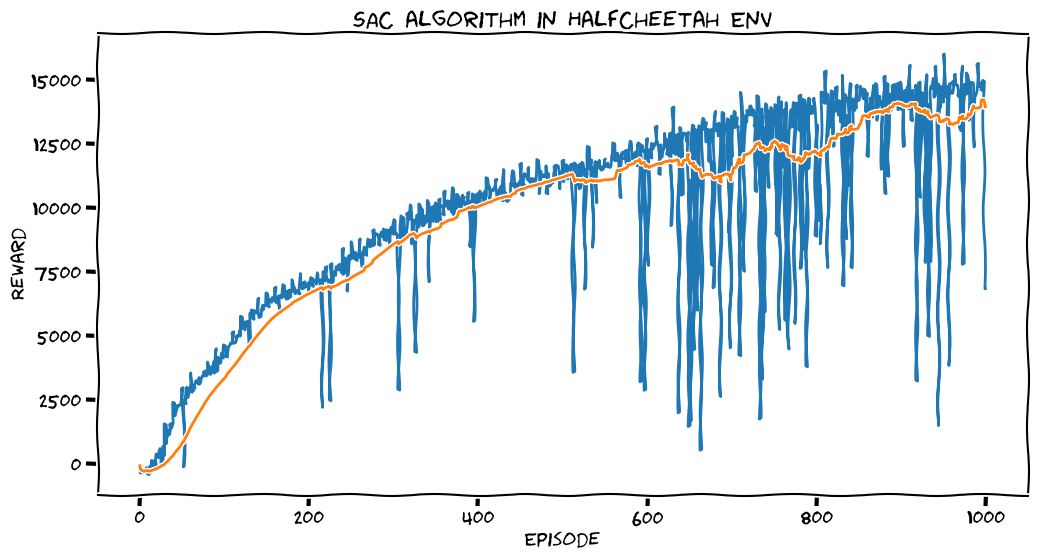

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [9]:
from tqdm import tqdm

total_numsteps = 0
updates = 0
reward_history = []
Max_episodes = 1000  # Training for 1000 episodes

pbar = tqdm(range(Max_episodes), desc="SAC Training Episodes")
for i_episode in pbar:
    episode_steps = 0
    done = False
    state, _ = env.reset()
    episode_reward = 0

    while not done:
        # Use random actions for initial exploration
        if config['start_steps'] > total_numsteps:
            action = env.action_space.sample()
        else:
            action = agent.select_action(state)

        # Update agent's parameters if replay memory is sufficiently filled
        if len(memory) > config['batch_size']:
            critic_1_loss, critic_2_loss, policy_loss, ent_loss, alpha = agent.update_parameters(memory, config['batch_size'], updates)
            updates += 1

        next_state, reward, done, truncated, _ = env.step(action)
        episode_steps += 1
        total_numsteps += 1
        done = done or truncated

        # Create a mask: 1 if reached max episode steps, otherwise based on done signal
        mask = 1 if episode_steps == env._max_episode_steps else float(not done)

        memory.push(state, action, reward, next_state, mask)
        state = next_state
        episode_reward += reward

    # Evaluate policy every 10 episodes using deterministic policy (evaluate=True)
    if i_episode % 10 == 0:
        eval_rewards = []
        num_eval_episodes = 5
        for _ in range(num_eval_episodes):
            state_eval, _ = env.reset()
            eval_ep_reward = 0
            done_eval = False
            while not done_eval:
                action_eval = agent.select_action(state_eval, evaluate=True)
                state_eval, reward_eval, done_eval, truncated_eval, _ = env.step(action_eval)
                eval_ep_reward += reward_eval
                done_eval = done_eval or truncated_eval
            eval_rewards.append(eval_ep_reward)
        avg_reward = np.mean(eval_rewards)
    else:
        avg_reward = episode_reward

    reward_history.append(avg_reward)

    # Update tqdm progress bar with current episode details
    pbar.set_postfix({
        "Episode": i_episode,
        "Reward": f"{avg_reward:.2f}",
        "TotalSteps": total_numsteps
    })

env.close()
plot_rewards(reward_history, show_result='SAC algorithm in HalfCheetah Env')


In [10]:
env = gym.make("HalfCheetah-v4", render_mode="rgb_array")
state, _ = env.reset()
frames = []

total_reward = 0
done = False  # Initialize the done flag

while not done:
    frames.append(env.render())  # Capture the current frame
    action = agent.select_action(state, evaluate=True)  # Use deterministic policy
    next_state, reward, done, truncated, _ = env.step(action)
    total_reward += reward

    # If truncated is True (time limit reached), we also treat the episode as done
    done = done or truncated
    state = next_state

env.close()
print(f'Total Reward: {total_reward}')

# Save frames to MP4
imageio.mimsave('./eval_SAC.mp4', frames, fps=25)

# Display the MP4 video in the notebook
show_video('./eval_SAC.mp4')


Total Reward: 15814.702025808298


# **Initialize DDPG** 

In [11]:
# Updated Configuration dictionary for DDPG
config = {
    "env_name": "HalfCheetah-v4",
    "policy": "Deterministic",  # For DDPG, we use the deterministic policy
    "gamma": 0.99,
    "tau": 0.005,

    # Default LR or separate ones for actor and critic
    "lr": 3e-4,           # Fallback if critic_lr/actor_lr not set
    "critic_lr": 3e-4,    # Critic learning rate
    "actor_lr": 3e-4,     # Actor learning rate

    "seed": 123456,
    "automatic_entropy_tuning": False,  # Not used in DDPG
    "batch_size": 256,
    "num_steps": 1000001,

    # Larger hidden size for better capacity
    "hidden_size": 512,

    "updates_per_step": 1,
    "start_steps": 10000,
    "target_update_interval": 1,
    "replay_size": 1000000,

    # Enable GPU if available
    "cuda": True,         
    
    "eval_interval": 1,
    
    # Alpha required for SAC compatibility; set to 0 for DDPG
    "alpha": 0.0,

    # Optional gradient clipping
    "max_grad_norm": 5.0,
}

# Setup the environment
env = gym.make(config["env_name"])
env.action_space.seed(config["seed"])

# Set random seeds
torch.manual_seed(config["seed"])
np.random.seed(config["seed"])

# Initialize DDPG agent (we reuse the SAC class, but it selects DeterministicPolicy for DDPG)
agent = SAC(env.observation_space.shape[0], env.action_space, config)

# Initialize replay memory
memory = ReplayMemory(config["replay_size"], config["seed"])


# **Train the DDPG here**

DDPG Training Episodes: 100%|██████████| 1000/1000 [2:55:38<00:00, 10.54s/it, Episode=999, Reward=10810.85, TotalSteps=1e+6]


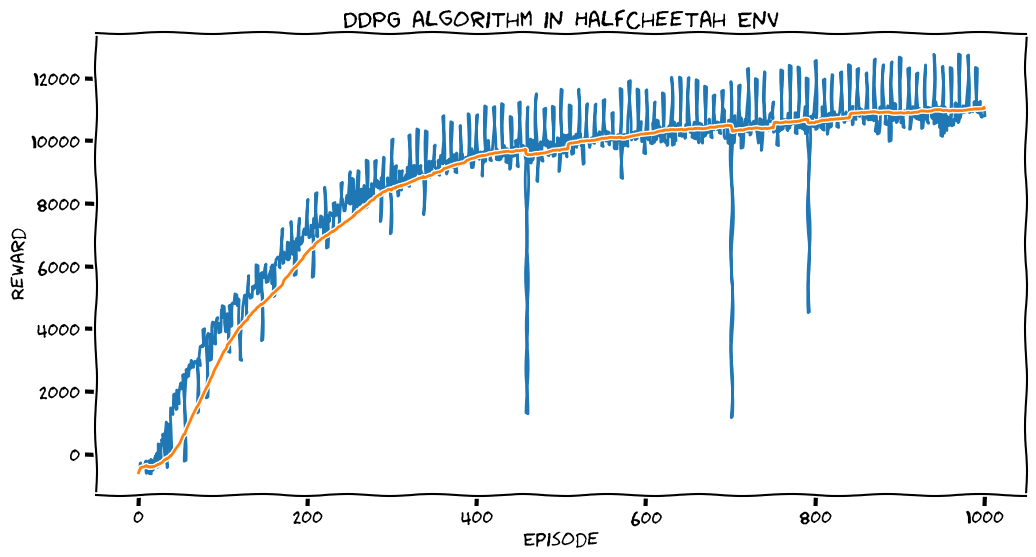

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [12]:
from tqdm import tqdm

total_numsteps = 0
updates = 0
reward_history = []
Max_episodes = 1000  # Training for 1000 episodes

pbar = tqdm(range(Max_episodes), desc="DDPG Training Episodes")
for i_episode in pbar:
    episode_steps = 0
    done = False
    state, _ = env.reset()
    episode_reward = 0

    while not done:
        # Use random actions for exploration until start_steps is reached
        if config['start_steps'] > total_numsteps:
            action = env.action_space.sample()
        else:
            action = agent.select_action(state)

        # Update parameters if we have enough samples in the replay buffer
        if len(memory) > config['batch_size']:
            critic_1_loss, critic_2_loss, policy_loss, ent_loss, alpha = agent.update_parameters(
                memory, config['batch_size'], updates
            )
            updates += 1

        next_state, reward, done, truncated, _ = env.step(action)
        episode_steps += 1
        total_numsteps += 1
        done = done or truncated

        # Mask is 1 if we reach the max episode steps, else float(not done)
        mask = 1 if episode_steps == env._max_episode_steps else float(not done)

        # Store the transition
        memory.push(state, action, reward, next_state, mask)

        state = next_state
        episode_reward += reward

    # Evaluate the policy every 10 episodes using deterministic policy (evaluate=True)
    if i_episode % 10 == 0:
        eval_rewards = []
        num_eval_episodes = 5
        for _ in range(num_eval_episodes):
            state_eval, _ = env.reset()
            eval_ep_reward = 0
            done_eval = False
            while not done_eval:
                action_eval = agent.select_action(state_eval, evaluate=True)
                state_eval, reward_eval, done_eval, truncated_eval, _ = env.step(action_eval)
                eval_ep_reward += reward_eval
                done_eval = done_eval or truncated_eval
            eval_rewards.append(eval_ep_reward)
        avg_reward = np.mean(eval_rewards)
    else:
        avg_reward = episode_reward

    reward_history.append(avg_reward)

    # Update the tqdm progress bar
    pbar.set_postfix({
        "Episode": i_episode,
        "Reward": f"{avg_reward:.2f}",
        "TotalSteps": total_numsteps
    })

env.close()
plot_rewards(reward_history, show_result='DDPG algorithm in HalfCheetah Env')


In [13]:
env = gym.make("HalfCheetah-v4", render_mode="rgb_array")
state, _ = env.reset()
frames = []

total_reward = 0
done = False  # Initialize the done flag

while not done:
    frames.append(env.render())  # Capture the current frame
    action = agent.select_action(state, evaluate=True)  # Deterministic action
    next_state, reward, done, truncated, _ = env.step(action)
    total_reward += reward

    # If truncated is True (time limit reached), consider episode done
    done = done or truncated
    state = next_state  # Update the state

env.close()
print(f"Total Reward: {total_reward}")

# Save frames to MP4
imageio.mimsave('./eval_DDPG.mp4', frames, fps=25)

# Display the MP4 video in the notebook
show_video('./eval_DDPG.mp4')


Total Reward: 12764.89755768544
